In [2]:
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import trange
from tqdm.notebook import tnrange
from torch.utils.data.dataset import ConcatDataset

from sklearn import preprocessing
import pandas as pd
import os
import argparse
import logging
from torch.autograd import Function
import matplotlib.pyplot as plt
from bayesian_model import BayesianModel as bm
from pycm import ConfusionMatrix

from secml.array.c_array import CArray

In [3]:
logging.basicConfig(format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.DEBUG)


class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


In [4]:
class Net(nn.Module):

    def __init__(self, input_shape, grl_lambda=100):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self._grl_lambda = grl_lambda
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        if self._grl_lambda != 0:
            self.grl = GradientReversal(grl_lambda)
            self.fc5 = nn.Linear(32, 2)
        # self.grl = GradientReversal(100)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.1)

        hidden = self.fc2(x)
        hidden = F.relu(hidden)
        hidden = F.dropout(hidden, 0.1)

        hidden = self.fc3(hidden)
        hidden = F.relu(hidden)
        hidden = F.dropout(hidden, 0.1)

        y = self.fc4(hidden)
        # y = F.dropout(y, 0.1)

        if self._grl_lambda != 0:
            s = self.grl(hidden)
            s = self.fc5(s)
            # s = F.sigmoid(s)
            # s = F.dropout(s, 0.1)
            return y, s, hidden
        else:
            return y

In [8]:
model = Net(18)

In [11]:
model.load_state_dict(torch.load("../results/compas_2020_03_25_15h22m13s/model.pt"))

<All keys matched successfully>

In [22]:
from script_test_secML_attack_on_Keras_model import attack_keras_model, transform_dataset

df = pd.read_csv(os.path.join("..", "data", "csv", "scikit",
                                      "compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv"))
df_binary, Y, S, Y_true = transform_dataset(df)
Y = Y.to_numpy()
l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1, 1).astype(np.float32))


x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
# Just duplicate y twice to maintain correct order
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor)  # dataset = CustomDataset(x_tensor, y_tensor)

base_size = len(dataset) // 10
split = [7 * base_size, 1 * base_size, len(dataset) - 8 * base_size]  # Train, validation, test

train_dataset, val_dataset, test_dataset = random_split(dataset, split)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

(5278, 12)


In [23]:
model(test_loader)

AttributeError: 'DataLoader' object has no attribute 'dim'

In [24]:
device = "cpu"
grl_lambda = 1

with torch.no_grad():
    test_losses = []
    test_results = []
    hidden_layers = []
    for x_test, y_test, ytrue, s_true in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        s_true = s_true.to(device)
        model.eval()
        if grl_lambda is not None and grl_lambda != 0:
            yhat, s_hat, hidden = model(x_test)
            test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
        else:
            yhat = model(x_test)
            test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true})

In [26]:
hidden.shape

torch.Size([1062, 32])

In [40]:
X_embedded = TSNE(n_components=2).fit_transform(hidden)
X_embedded.shape

prediction = pd.DataFrame()

prediction['x0'] = X_embedded[:,0]
prediction['x1'] = X_embedded[:,1]
prediction['race_string'] = s_true[:,0]

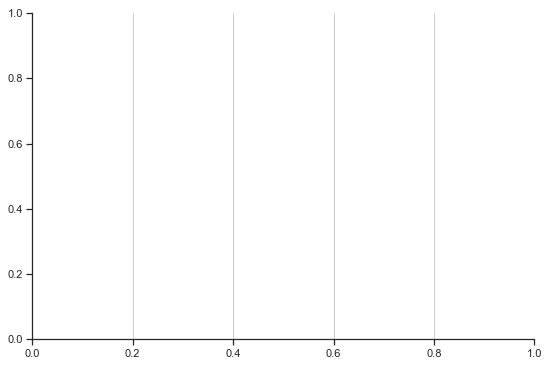

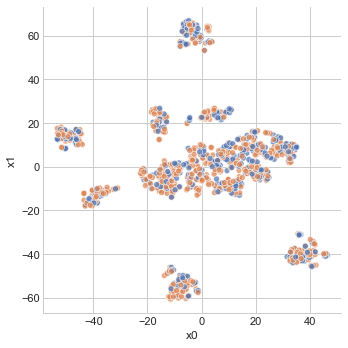

In [49]:
import seaborn as sns

sns.set(style="ticks")

f, ax = plt.subplots(figsize=(9, 6))
plt.style.use('seaborn-whitegrid')


ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)
sns.relplot(x="x0", y="x1", hue="race_string", alpha=0.7, data=prediction, legend=None)
plt.savefig("tsne_debiased.png", dpi=300)

In [30]:
prediction

,x0,x1
0,0.120016,-54.945488
1,2.926034,56.105888
2,-23.390429,-6.776347
3,12.693151,-4.484384
4,-31.811859,2.517820
...,...,...
1057,-31.638575,-7.471252
1058,12.437762,58.361328
1059,-3.290787,1.820836
1060,8.176648,50.729729


tensor([1., 1., 1.,  ..., 0., 1., 0.], dtype=torch.float64)